In [1]:
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible

from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
from stardist.models import StarDist2D

import skimage.segmentation as seg
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color
from skimage.measure import regionprops, label

np.random.seed(6)
lbl_cmap = random_label_cmap()

## Load StarDist model

First, we load the pre-trained StarDist model `2D_versatile_fluo`

In [2]:
model = StarDist2D.from_pretrained('2D_versatile_fluo')

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


## Load data

Next, we load images from a local subfolder to begin analysis.

In [40]:
X = sorted(glob(r'C:\Users\jv92c\Documents\mFISH\sample_data\test_images\*.tif'))
X = list(map(imread,X))

n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

## Analysis

First, we test the strength of prediction by loading one image from the sorted list.
The test image is then normalized and the function is called.

In [4]:
img = normalize(X[2], 1,99.8, axis=axis_norm)
labels, details = model.predict_instances(img)

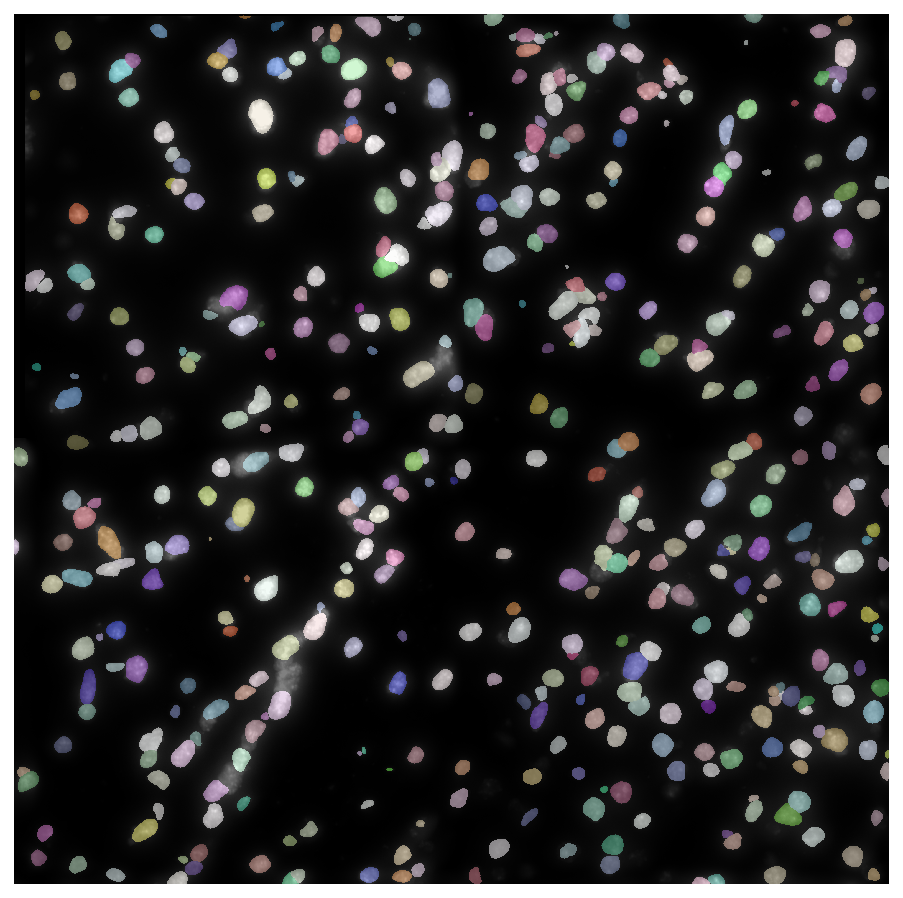

In [5]:
plt.figure(figsize=(8,8))
plt.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
plt.axis('off');

## Initial results

StarDist is shown here to be capable of identifying nuclei in a robust manner. However, there seems to be a lack of resolution for severely overlapping nuclei, but the result is more than satisfactory. Some dimmer nuclei are missed, while smaller fragments are detected, but there doesn't seem to be any other sort of detection issues.

In [6]:
stardist_img = []
stardist_labels = []

for i in range(len(X)):
    img = normalize(X[i][0:3800, 0:3800], 1,99.8, axis=axis_norm)
    labels, details = model.predict_instances(img)
    img_plot = img if img.ndim==2 else img[...,0]
    
    stardist_img.append(img_plot)
    stardist_labels.append(labels)
    

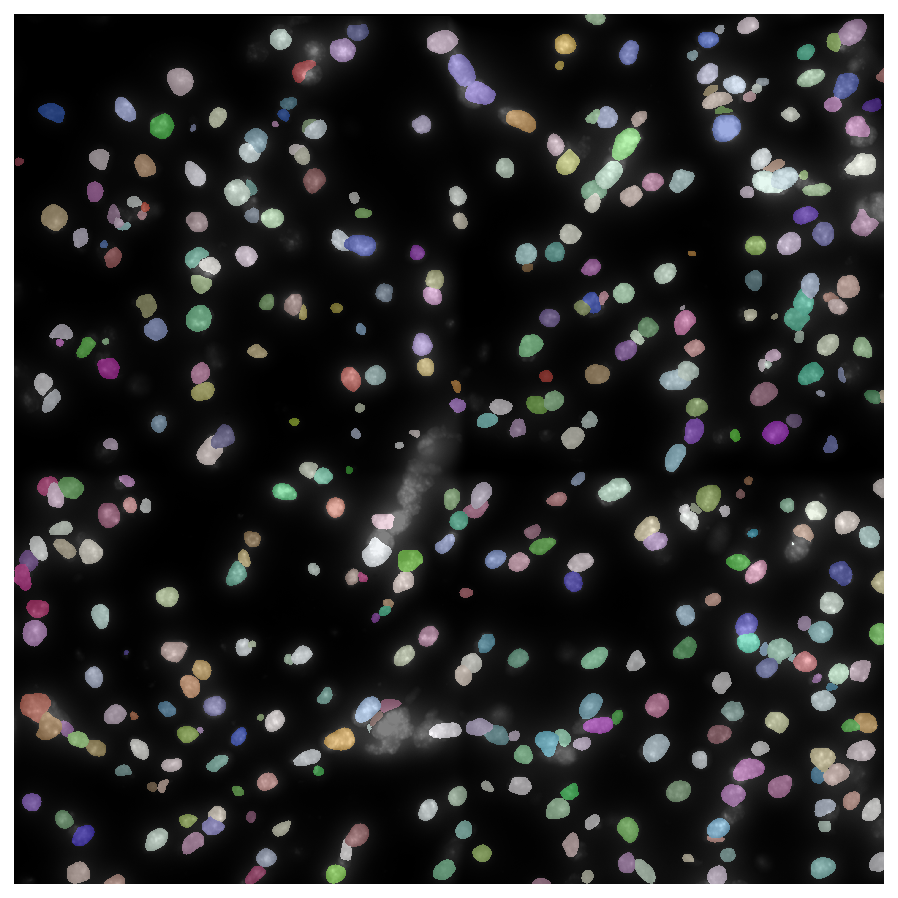

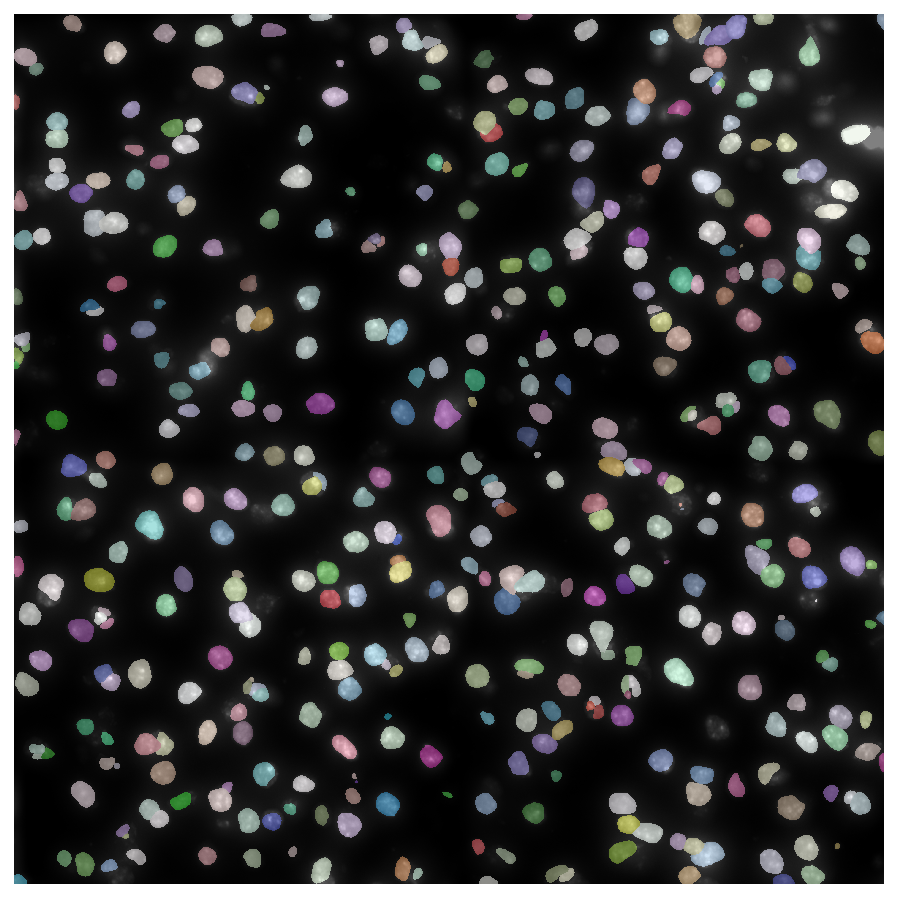

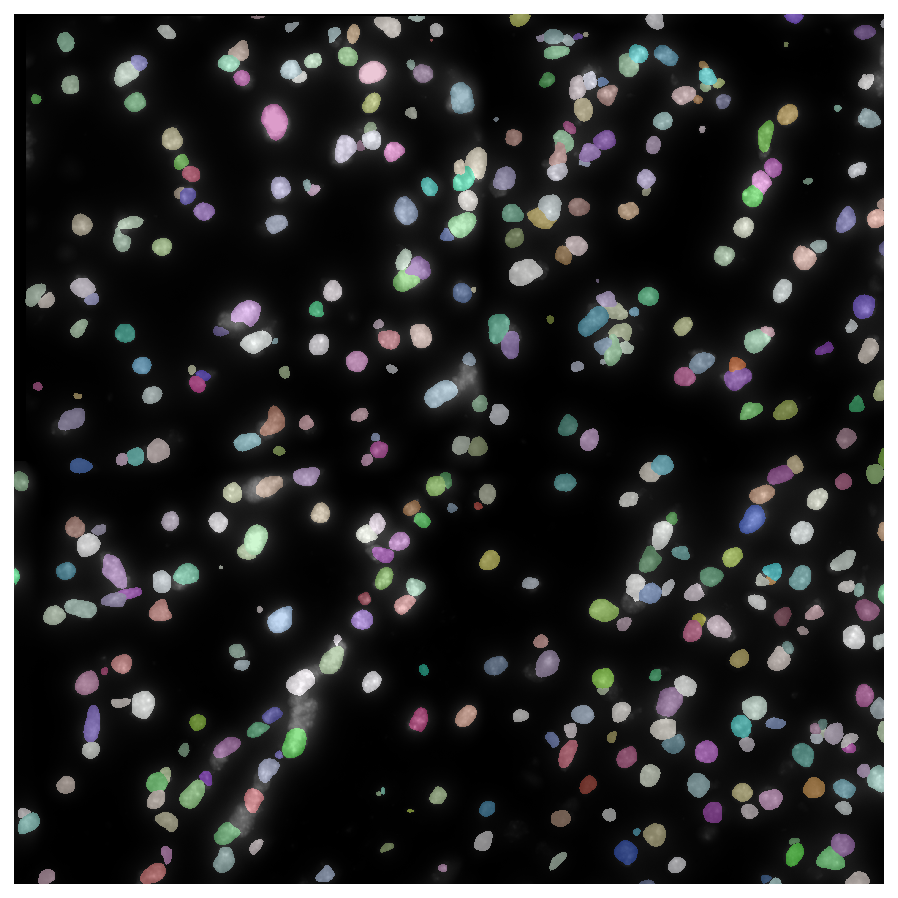

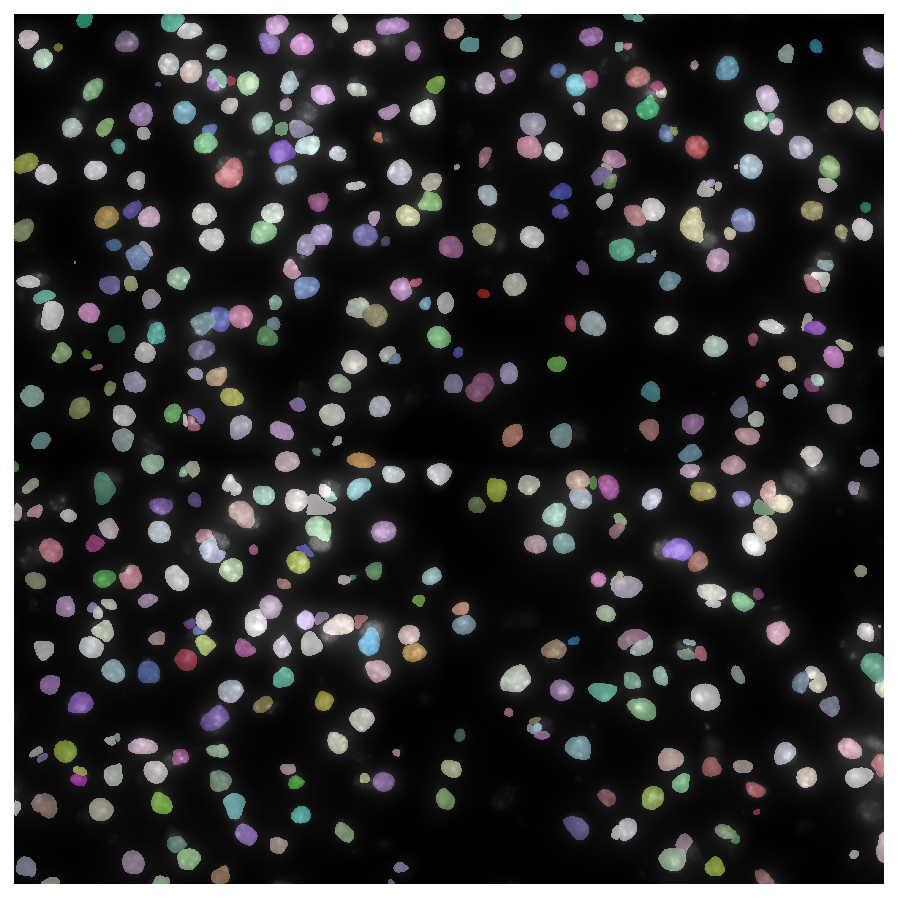

In [7]:
for ii, img in enumerate(stardist_img):
    
    plt.figure(figsize=(8,8))
    plt.imshow(img, clim=(0,1), cmap='gray')
    plt.imshow(stardist_labels[ii], cmap=lbl_cmap, alpha=0.5)
    plt.axis('off');


plt.show()

## Differences with Watershed

We explore the efficacy of StarDist by making a direct comparison using the same image set, but processed through Watershed instead. Then the two results are displayed side-by-side.

The watershed is applied as follows:

   - create a low-pass image by Difference-of-gaussians (sigmas of 150 and 1)
   - use Otsu thresholding
   - label images by use of skimage

In [8]:
#watershed process

processed_img = []

for i in range(len(X)):
    
    #use the same pre-processing for images in StarDist 
    img = normalize(X[i][0:3800, 0:3800], 1,99.8, axis=axis_norm)
    
    #gaussian of images using default settings
    img_gaussian_original = filters.gaussian(img, sigma=1, output=None, mode='nearest',cval=0,
                                             multichannel=None, preserve_range=False, truncate=4.0)
    
    #low-pass gaussian
    img_gaussian_mask = filters.gaussian(img, sigma=150, output=None, mode='nearest', cval=0, 
                                         multichannel=None, preserve_range=False, truncate=4.0)
    
    #thresholding and labeling
    img_subtracted = img_gaussian_original - img_gaussian_mask
    img_thresholded = img_subtracted > filters.threshold_otsu(img_subtracted)*0.87
    img_labeled = label(img_thresholded)
    
    #storing images in list
    processed_img.append(img_labeled)   

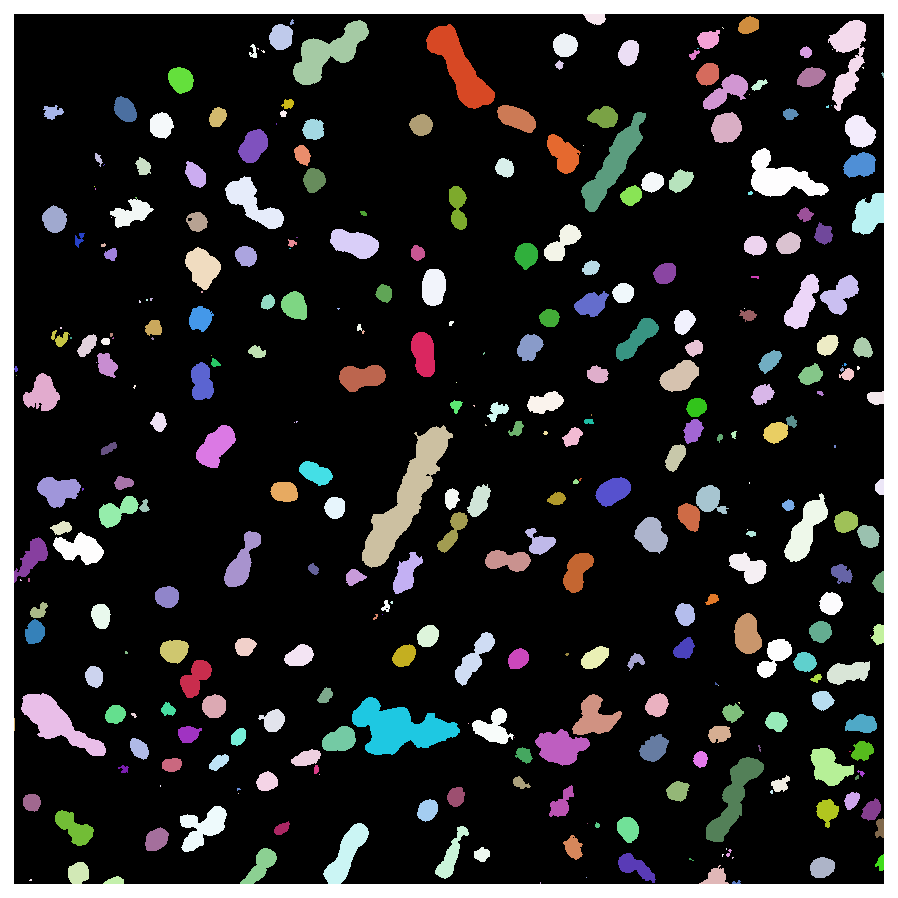

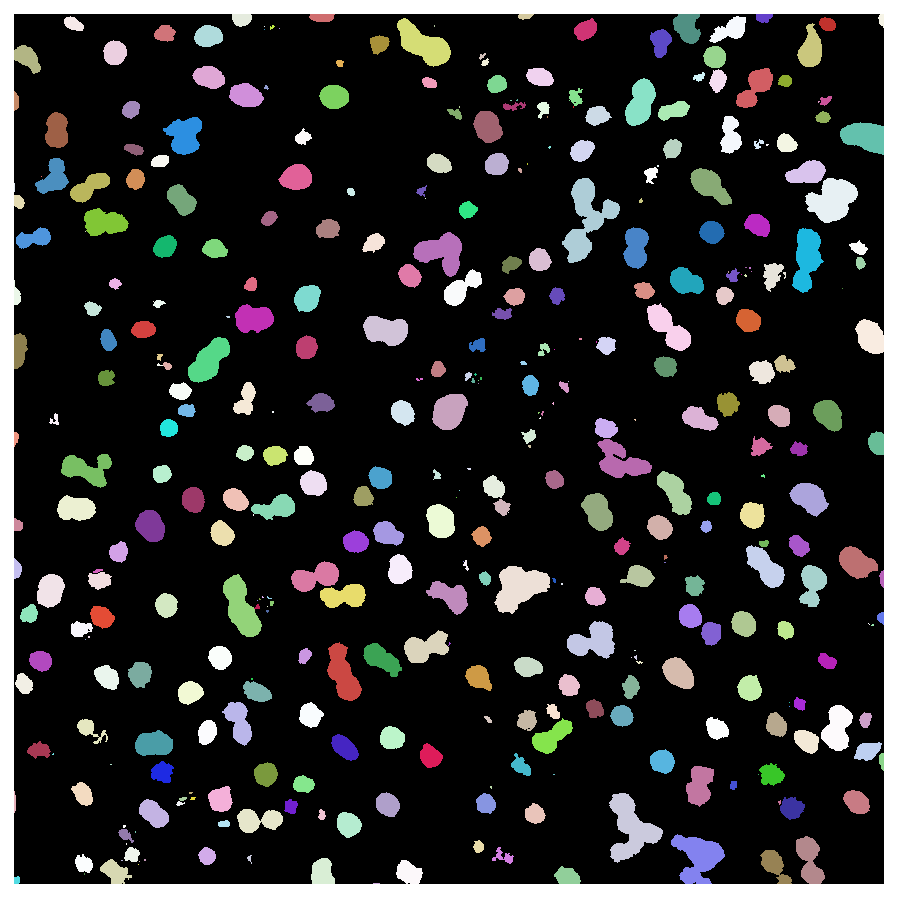

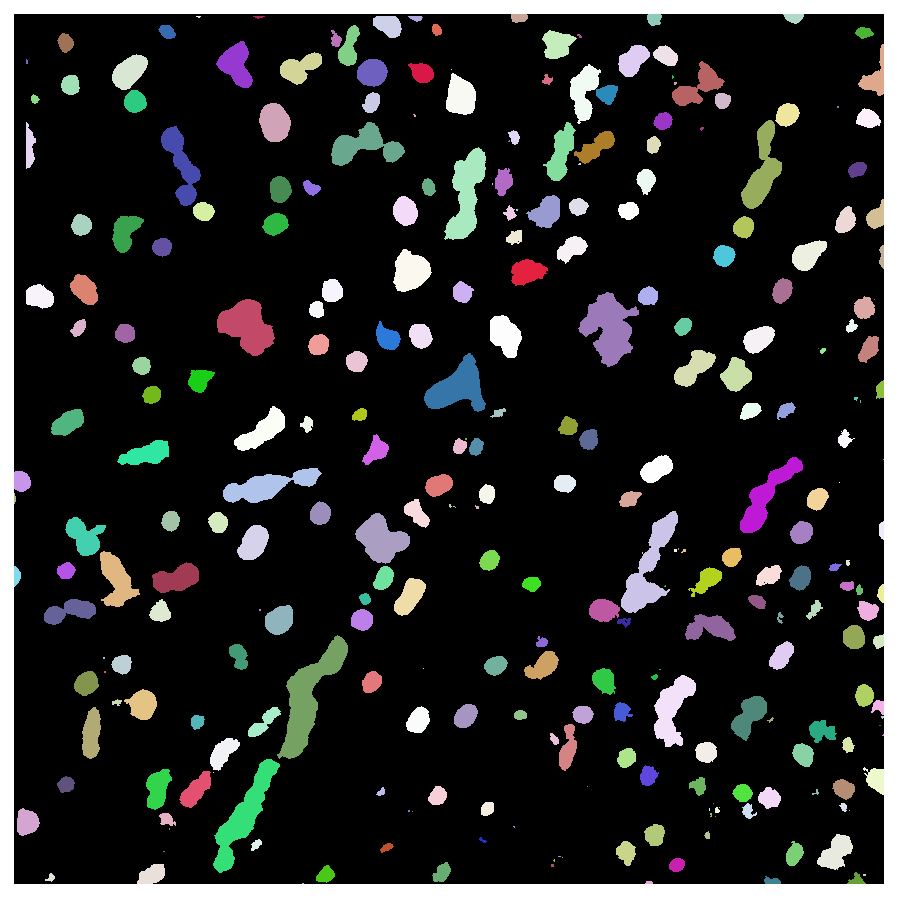

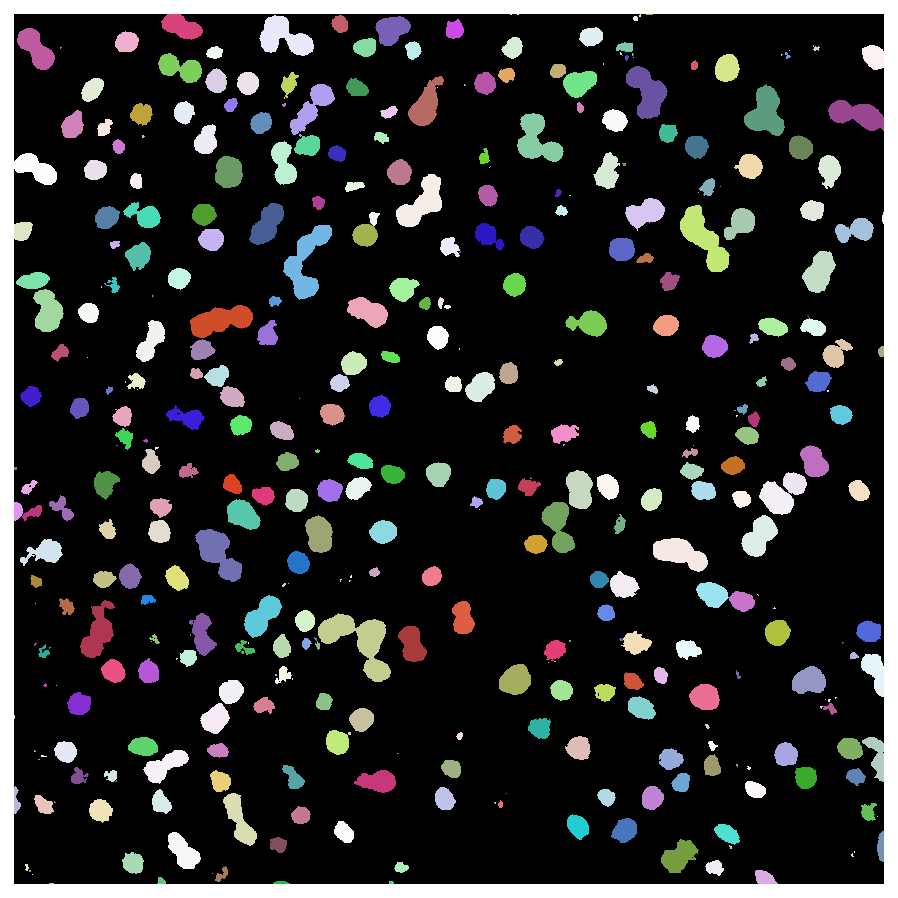

In [10]:
#showing watershed images
for img in processed_img:
    
    plt.figure(figsize=(8,8))
    plt.imshow(img, cmap=lbl_cmap)
    plt.axis('off');

plt.show()

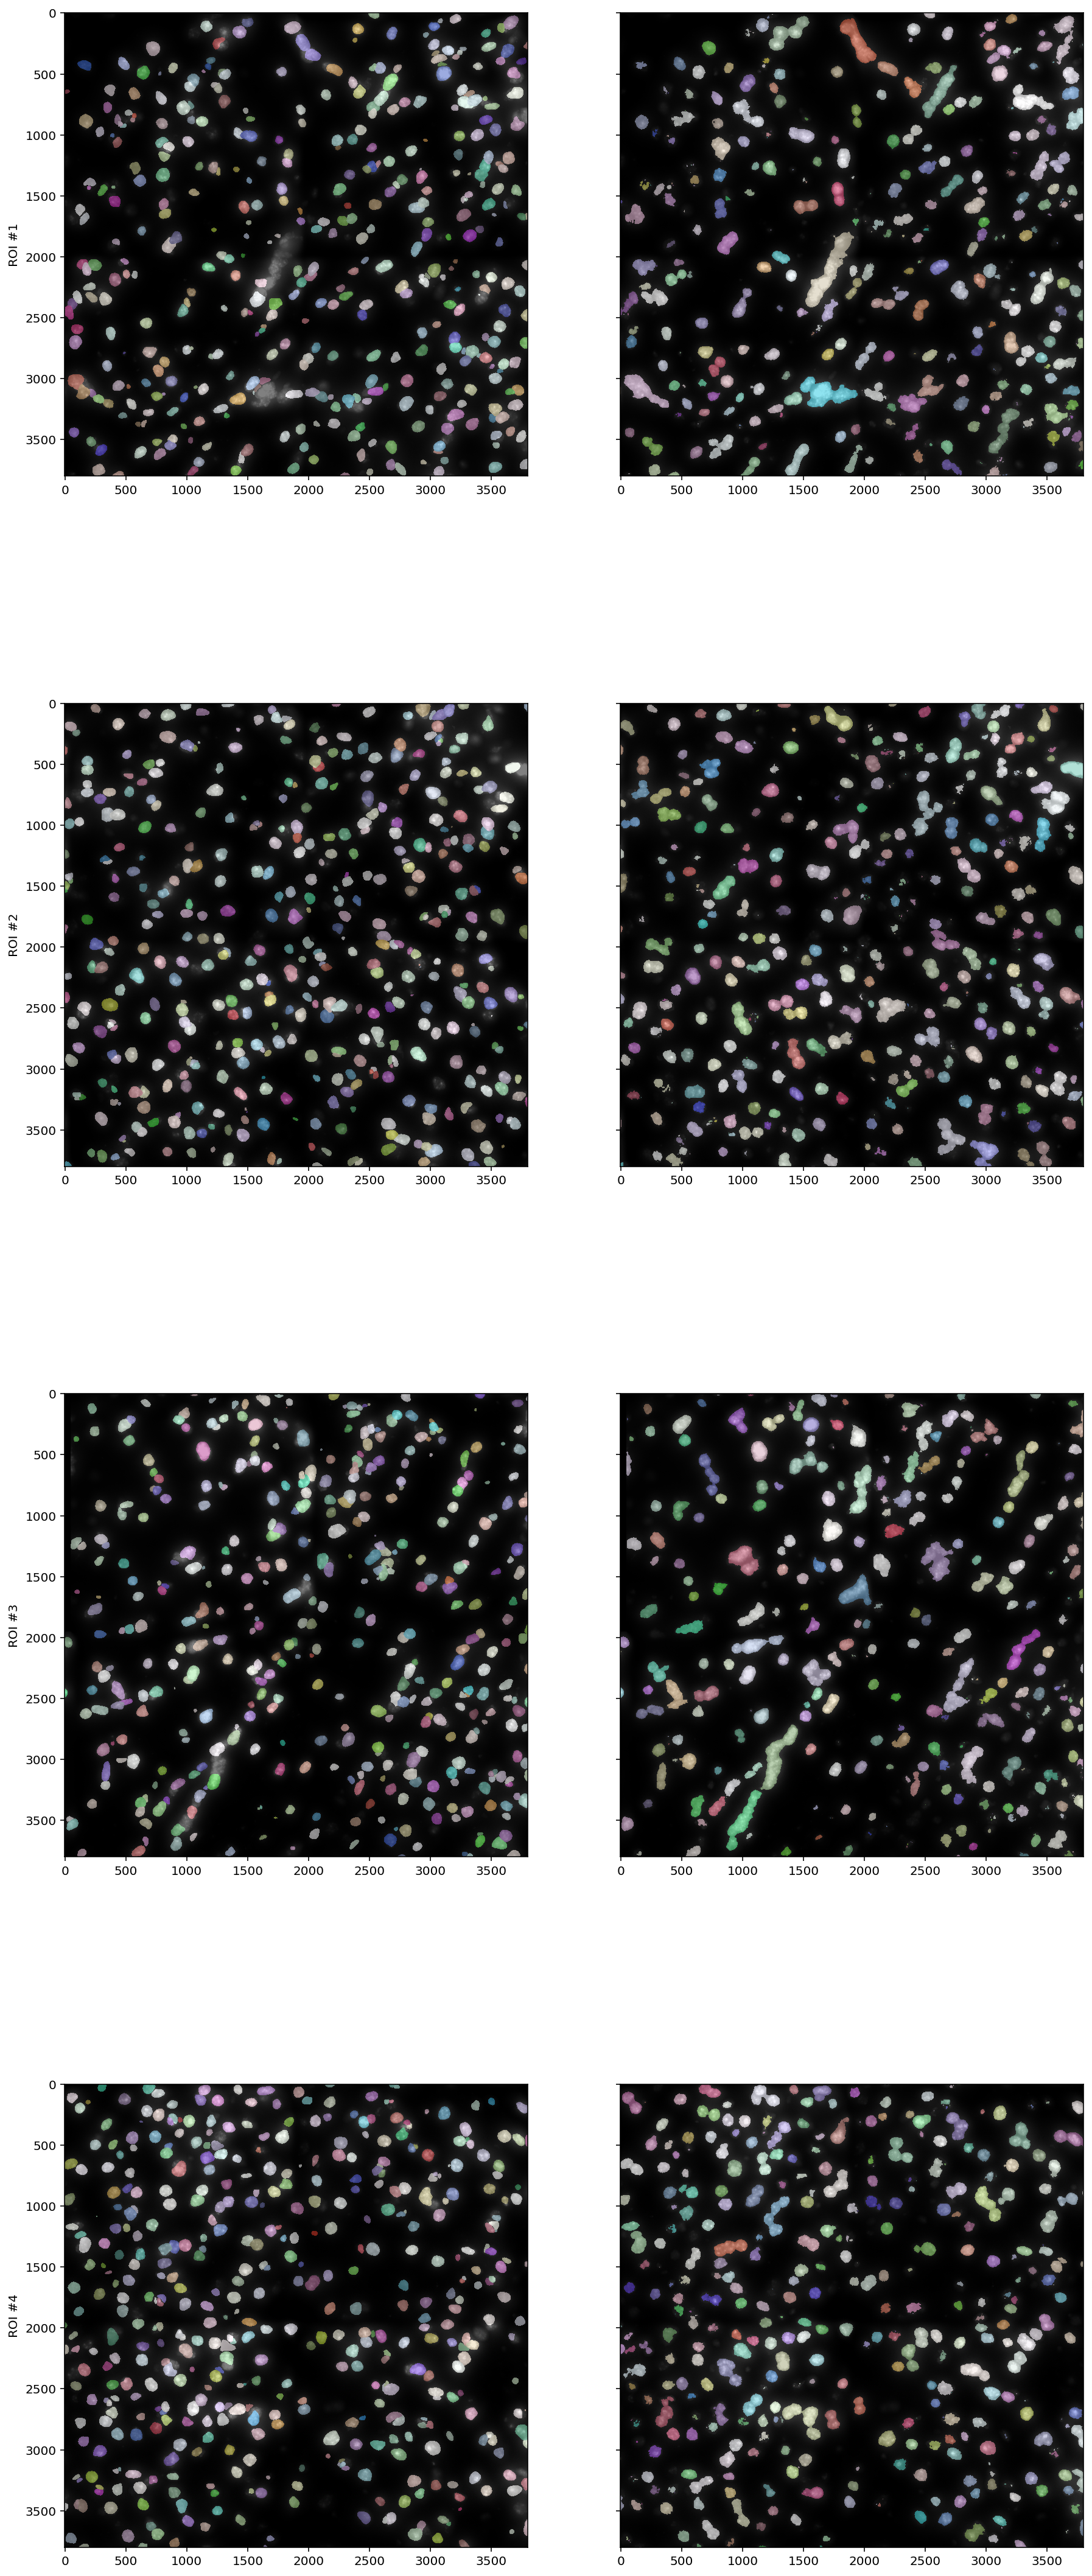

In [38]:
#side-by-side comparison
fig, ax = plt.subplots(4,2, sharey=True, figsize=(15,40))

for ii, img in enumerate(stardist_img):
    
    ax[ii, 0].imshow(img, clim=(0,1), cmap='gray')
    ax[ii, 0].imshow(stardist_labels[ii], cmap=lbl_cmap, alpha=0.5)
    ax[ii, 0].set_ylabel('ROI #'+str(ii+1))
    
for jj, imgs in enumerate(processed_img):
    
    '''
    this first imshow line is for calling the pre-processed images used in stardist
    which doesn't include any generated polygons, for a more direct comparison
    '''
    ax[jj, 1].imshow(stardist_img[jj], clim=(0,1), cmap='gray')
    ax[jj, 1].imshow(imgs, cmap=lbl_cmap, alpha=0.5)            

## Conclusion 

As observed in the preceding images, StarDist is able to segment nuclei clusters, and for more eccentric groups, they are immediately bypassed for a more accurate analysis. Moreover, there are less occurences of nuclei fragments being detected, and partial nuclei in edge cases are also ignored. There is a slight discrepancy in detection, as the watershed is able to identify dimmer signal. Perhaps with the development of a custom training model, this issue may be resolved, and segmentation improved.